# Package that we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from scipy.stats import multivariate_normal


# you can choose one of the following package for image reading/processing

import cv2
from PIL import Image


## 1 Support Vector Machine

<style>
.blue{
    color: skyblue;
}
.bold{
    font-weight: bold;
}
</style>

In the training procedure of SVM, we need to optimize with respect to the Lagrange multipliers
$a = \{ a_n \}$. 

Here, we use the <span class="blue">sequential minimal optimization</span> to solve the problem. 

For details, you can refer to the paper [Platt, John. “Sequential minimal optimization: 

A fast algorithm for training support vector machines”, 1998]. The classifier is written by

$$
    y(\textbf{x}) = \sum_{n=1}^N a_n t_n k(\textbf{x}, \textbf{x}_n) = \textbf{w}^T \textbf{x} + b
$$
$$
    \textbf{w} = \sum_{n=1}^N \alpha_n t_n \phi(\textbf{x}_n)
$$
$$
    b = \frac{1}{N_{\mathcal{M}}} \sum_{n \in \mathcal{M}} \left( t_n - \sum_{m \in \mathcal{S}} a_m t_m k(\textbf{x}_n, \textbf{x}_m) \right)
$$

where $\mathcal{M}$ denotes the set of indices of data points having $0 \lt a_n \lt C$.

### 1.1

It is popular to use principal component analysis (PCA) to reduce the dimension of images to d = 2. 

Please implement it by yourself instead of using the method from sklearn.

In [2]:
data = pd.read_csv("./x_train.csv",header= None)/255
label = pd.read_csv("./t_train.csv",header= None)

**PCA**

$\textbf{C}$ is covariance matrix of $\textbf{X}$, $\textbf{W}$ is the eigenvector matrix of $\textbf{C}$, $\Lambda$ is the eigenvalue matrix of $\textbf{C}$.

$\textbf{X}$ is the data matrix, $\textbf{X}_k$ is the data matrix after dimension reduction, and k in this task will be 2.

$$
    \textbf{C} = \frac{\textbf{X}^T \textbf{X}}{n - 1}
$$
$$
    \textbf{C} = \textbf{W} \Lambda \textbf{W}^{-1}
$$
$$
    \textbf{X}_k = \textbf{X} \textbf{W}_k
$$

**Using SVD to solve PCA**

$\Sigma$ is the singular value matrix of $\textbf{X}$, $\textbf{U}$ is the left singular vector matrix of $\textbf{X}$, $\textbf{V}$ is the right singular vector matrix of $\textbf{X}$.

$$
    \textbf{C} = \frac{\textbf{X}^T \textbf{X}}{n - 1} 
$$
$$
    \textbf{C} = \frac{\textbf{V}\Sigma\textbf{U}^T\textbf{U}\Sigma\textbf{V}^T}{n - 1}
$$
$$
    \textbf{C} = \textbf{V} \frac{\Sigma^2}{n - 1}\textbf{V}^T
$$
$$
    \textbf{C} = \textbf{V} \frac{\Sigma^2}{n - 1}\textbf{V}^{-1} \ \ (\rm{because} \ \textbf{V} \ \rm{is \ unitary})
$$

We can found that covariance matrix $\textbf{C}$ is the same as the eigenvalue matrix $\Lambda$ of $\textbf{V}^{-1}$.

$$
    \Lambda = \frac{\Sigma^2}{n - 1}
$$

In [3]:
data_new = data.values - np.mean(data.values, axis=0) # centralize data
np.allclose(data_new.mean(axis=0), np.zeros(data_new.shape[1])) # check if centralization is correct
C = (data_new.T @ data_new) / (data_new.shape[0] - 1) # covariance matrix
eig_vals, eig_vecs = np.linalg.eig(C) # eigenvalues and eigenvectors
eig_vals, eig_vecs = eig_vals.real, eig_vecs.real # convert to real numbers
# sort eigenvalues in ascending order   
eig_vals_sorted = np.argsort(eig_vals)[::1][-2:] # sort eigenvalues in ascending order and take the last two
data_pca = data_new @ eig_vecs[:,eig_vals_sorted] # PCA

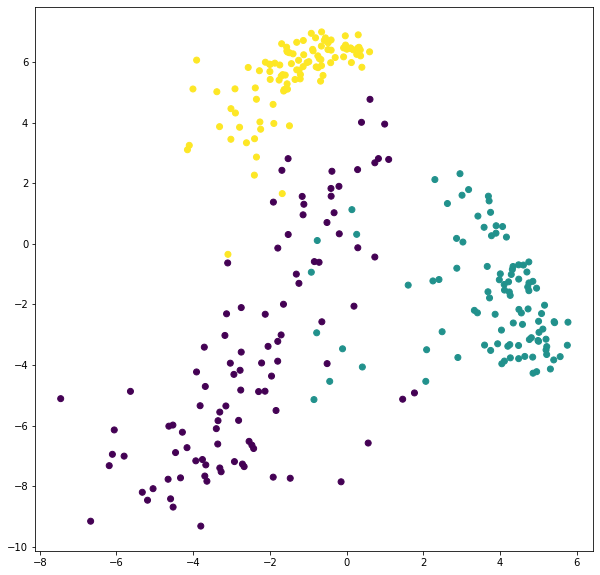

In [4]:
# plot 2D data with label
plt.figure(figsize=(10,10))
plt.scatter(data_pca[:,0],data_pca[:,1],c=label.values)
plt.show()

#### 1.2

Describe the difference between two decision approaches (one-versus-the-rest and one-
versus-one). 

Decide which one you want to choose and explain why you choose this approach.

<style>
.blue{
    color: skyblue;
}
.red{
    color: red;
}
.bold{
    font-weight: bold;
}
</style>

**One-versus-the-rest**

First, we train a binary classifier <span class="red">for each class</span>. 

Only one class is positive and the rest are negative.

Then, we use the classifier to predict the class of the test data. 

Finally, we choose the class with the highest score.

**One-versus-one**

We train a binary classifier <span class="red">for each pair of classes</sapn>. 

Then, we use the classifier to predict the class of the test data. 

The test data is assigned to the class that wins the most duels.

Finally, we choose the class with the highest score.

**Which one to choose**

Support vector machine is a binary classifier.

If we use one-versus-the-rest, we need to train $C$ binary classifiers.

If we use one-versus-one, we need to train $\frac{C(C-1)}{2}$ binary classifiers.

If $C$ is large, <span class = "red">one-versus-one is better</sapn>.

#### 1.3

<style>
.blue{
    color: skyblue;
}
.bold{
    font-weight: bold;
}
</style>

Use the principle values projected to top <span class="blue">two</span> eigenvectors obtained from PCA, and build
a SVM with <span class="blue">linear kernel</span> to do multi-class classification. 

You can decide the upper bound $C$ of $a_n$ by yourself or just use the default value provided by sklearn. 

Then, <span class="blue">plot the corresponding decision boundary</span> and show the <span class="blue">support vectors.</span>

* Linear kernel:
$$
    k(\textbf{x}_i, \textbf{x}_j) = \phi(\textbf{x}_i)^T \phi(\textbf{x}_j) = \textbf{x}_i^T \textbf{x}_j
$$

The sample figures are provided below.

<center>
    <img src = "./image/figure1.png" width = 50%>
</center>

In [5]:
data.values.shape

(300, 784)

In [6]:
label.shape

(300, 1)

#### Bonus

<style>
.blue{
    color: skyblue;
}
.bold{
    font-weight: bold;
}
</style>

Repeat 3 with <span class="blue">polynomial kernel (degree = 2).</span>

* Polynomial (homogeneous) kernel of degree 2:

$$
    k(\textbf{x}_i, \textbf{x}_j) = \phi(\textbf{x}_i)^T \phi(\textbf{x}_j) = \left( \textbf{x}_i^T \textbf{x}_j\right)^2
$$
$$
    \phi(\textbf{x}) = \left[ \textbf{x}_1^2, \sqrt{2} \textbf{x}_1 \textbf{x}_2, \textbf{x}_2^2 \right]
$$
$$
    \textbf{x} = \left[ x_1, x_2 \right]
$$

## 2 Gaussian Mixture Model

<style>
.blue{
    color: skyblue;
}
.red{
    color: red;
}
.bold{
    font-weight: bold;
}
</style>

In this exercise, you will implement a Gaussian mixture model (GMM) and apply it in image segmentation. 

First, use a $K$-means algorithm to find $K$ central pixels. 

Second, use the expectation maximization (EM) algorithm <span class="blue">(please refer to textbook p.438-p.439)</span> to optimize the parameters of the model. 

The input image is given by <span class="red">hw3.jpg</span>. 

According to the maximum likelihood, you can decide the color $\mu_k$ , $k \in [1, . . . , K]$ of each pixel $x_n$ of output image

#### 2.1

Please build a $K$-means model by minimizing

$$
    J = \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk} \| x_n - \mu_k \|^2
$$

and show the table of the estimated $\{ \mu_k \}^K_{k=1}$.

In [7]:
np.random.seed(42)

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class KMeans():
    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps
        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]
        # the centers (mean feature vector) for each cluster
        self.centroids = []
        
    def predict(self, X):
        self.X = X
        self.n_samples, self.n_features = X.shape
        
        # initialize 
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]
        # Optimize clusters
        for _ in range(self.max_iters):
            # Assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)
            if self.plot_steps:
                self.plot()
            # Calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)
            
            # check if clusters have changed
            if self._is_converged(centroids_old, self.centroids):
                break
            if self.plot_steps:
                self.plot()
        # Classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)
    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                labels[sample_index] = cluster_idx
        return labels
    def _create_clusters(self, centroids):
        # Assign the samples to the closest centroids to create clusters
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters
    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index
    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids
    def _is_converged(self, centroids_old, centroids):
        # distances between each old and new centroids, fol all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0
    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        for i, index in enumerate(self.clusters):
            point = self.X[index].T
            ax.scatter(*point)
        for point in self.centroids:
            ax.scatter(*point, marker="x", color='black', linewidth=2)
        plt.show()
    def cent(self):
        return self.centroids

In [8]:
image = cv2.imread("./hw3.jpg")
pixel_values = image.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
print(pixel_values.shape)

(177000, 3)


In [9]:
k_slot = [2, 3, 7, 20]
for k_idx in k_slot:
    k = KMeans(K=k_idx, max_iters=2)
    print("K = ", k_idx)
    y_pred = k.predict(pixel_values)
    centers = np.uint8(k.cent())
    # print center values with RGB format
    y_pred = y_pred.astype(int)
    labels = y_pred.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    centers_table = pd.DataFrame(centers, columns=["R", "G", "B"])
    print(centers_table)
    print("*" * 50)

K =  2
     R    G    B
0   26   57   26
1  129  151  146
**************************************************
K =  3
     R    G    B
0   21   52   23
1   83  114   73
2  157  172  194
**************************************************
K =  7
     R    G    B
0  182  194  217
1   81  103  123
2  100  134   76
3   23   63   27
4   59   92   47
5  128  146  170
6   15   36   17
**************************************************
K =  20
      R    G    B
0    15   44   18
1   134  155  186
2    35   57   30
3   102  125  154
4    13   36   15
5    52   75   95
6    53   82   37
7    86  118   67
8    12   40   16
9    18   64   25
10   19   51   21
11  162  175  195
12   23   37   17
13  202  212  235
14   24   84   37
15   12   30   18
16   12   23   13
17  224  232  247
18  183  194  218
19  120  148  102
**************************************************


[$\mu_k$ , $k \in [1, . . . , K]$](./KMeans_mu.txt)

#### 2.2

<style>
.blue{
    color: skyblue;
}
.red{
    color: red;
}
.bold{
    font-weight: bold;
}
</style>

Use $ \mu = \{ \mu_k \}^K_{k=1}$ calculated by the $K$-means model as the means, and calculate the corresponding variances $ \sigma_k^2 $ 

and mixing coefficient $\pi_k$ for the initialization of the GMM $p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x \ | \ \mu_k, \sigma_k^2)$.

Optimize the model by maximizing the log likelihood function $\log \ p(x \ | \ \pi, \mu, \sigma^2)$ over N pixels through EM algorithm. 

<span class="red">Plot the learning curve for log likelihood of GMM.</span> <span class="blue">(Please terminate EM algorithm when the number of iterations arrives at 100.)</span>

In [10]:
class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)
        self.loglikelihood = []

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def recode_likelihood(self, likelihood):
        # loglikelihood = np.mean(np.log(np.sum(likelihood, axis=0)))
        loglikelihood = np.sum(np.log(np.sum(likelihood, axis=0)))
        self.loglikelihood.append(loglikelihood)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            self.recode_likelihood(self.likelihood)
            
    def predict_proba(self, X):
        self.likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            self.likelihood[:,i] = distribution.pdf(X)
        
        numerator = self.likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [11]:
def plot_loglikelihood(model):
    iter = np.arange(len(model.loglikelihood))
    plt.plot(iter+1, model.loglikelihood)
    plt.title(f'Log Likelihood k = {model.k}')
    plt.xlabel('Iterations')
    plt.ylabel('Log Likelihood')
    plt.show()

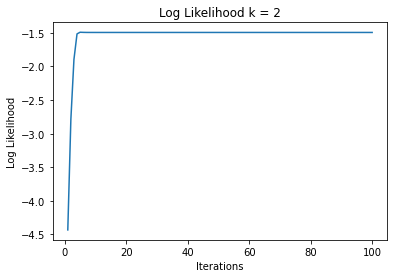

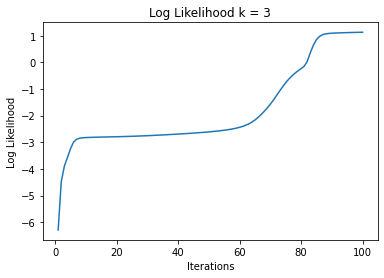

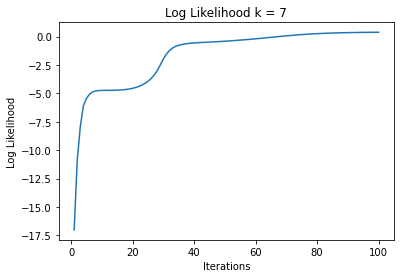

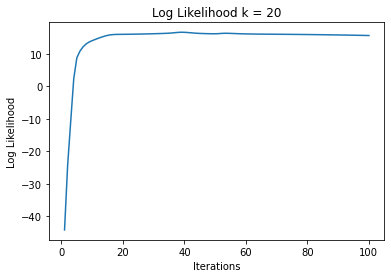

In [12]:
np.random.seed(42)
k_slot = [2, 3, 7, 20]
for k_idx in k_slot:
    gmm = GMM(k=k_idx, max_iter=100)
    gmm.fit(pixel_values)
    plot_loglikelihood(gmm)

<center>
    <table>
        <tr>
            <th>    
                K
            </th>
            <th>
                Log likelihood
            </th>
        </tr>
        <tr>
            <td>
                2
            </td>
            <td>
                <img src = "./image/log_2.png">
            </td>
        </tr>
        <tr>
            <td>
                3
            </td>
            <td>
                <img src = "./image/log_3.png">
            </td>
        </tr>
        <tr>
            <td>
                7
            </td>
            <td>
                <img src = "./image/log_7.png">
            </td>
        </tr>
        <tr>
            <td>
                20
            </td>
            <td>
                <img src = "./image/log_20.png">
            </td>
        </tr>
    </table>
</center>

#### 2.3

Repeat steps 1 and 2 for $K = 2, 3, 7$ and $20$. Please show the resulting images of $K$-means model and GMM, respectively. 

Below are some examples.

<center>
    <img src = "./image/figure2.png" width = 50%>
    <br><br>
    <table>
        <tr>
            <th>    
                &#9996
            </th>
            <th>
                K-means
            </th>
            <th>
                GMM
            </th>
        </tr>
        <tr>
            <td>
                <b>k = 2</b>
            </td>
            <td>
                <img src = "./image/kmeans_2.png">
            </td>
            <td>
                <img src = "./image/gmm_2.png">
            </td>
            </td>
        </tr>
        <tr>
            <td>
                <b>k = 3</b>
            </td>
            <td>
                <img src = "./image/kmeans_3.png">
            </td>
            <td>
                <img src = "./image/gmm_3.png">
            </td>
            </td>
        </tr>
        <tr>
            <td>
                <b>k = 7</b>
            </td>
            <td>
                <img src = "./image/kmeans_7.png">
            </td>
            <td>
                <img src = "./image/gmm_7.png">
            </td>
            </td>
        </tr>
        <tr>
            <td>
                <b>k = 20</b>
            </td>
            <td>
                <img src = "./image/kmeans_20.png">
            </td>
            <td>
                <img src = "./image/gmm_20.png">
            </td>
            </td>
        </tr>
</center>

K =  2


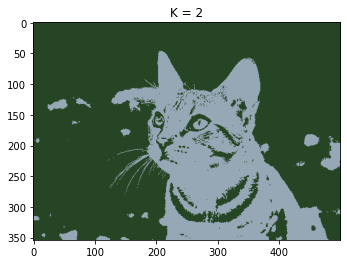

K =  3


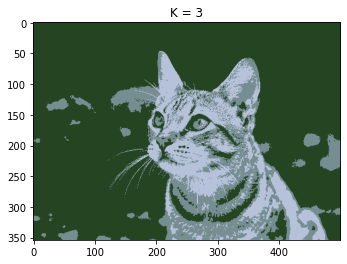

K =  7


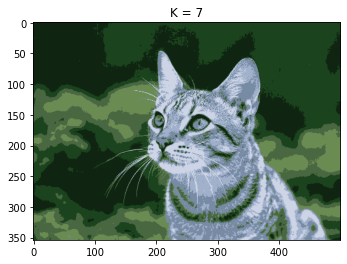

K =  20


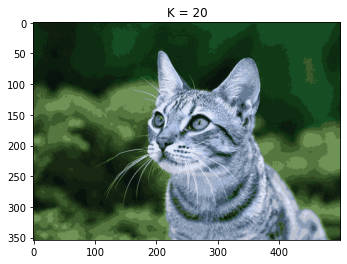

In [13]:
k_slot = [2, 3, 7, 20]
for k_idx in k_slot:
    k = KMeans(K=k_idx, max_iters=2)
    print("K = ", k_idx)
    y_pred = k.predict(pixel_values)
    centers = np.uint8(k.cent())
    # print center values with RGB format
    y_pred = y_pred.astype(int)
    labels = y_pred.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    # plot the image
    plt.title("K = " + str(k_idx))
    plt.imshow(segmented_image)
    plt.show()

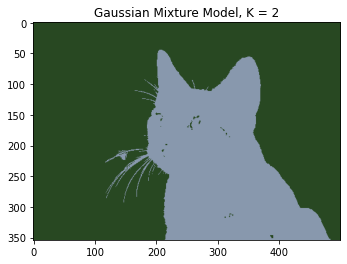

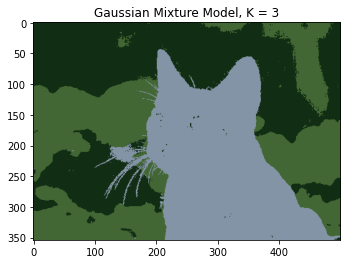

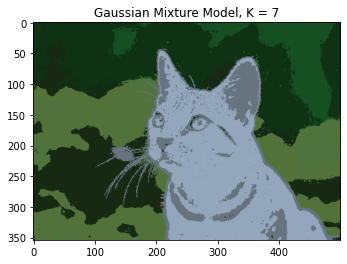

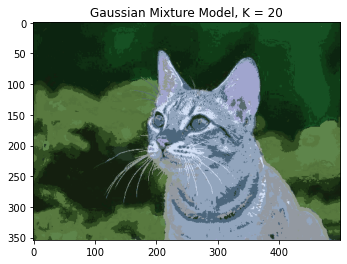

In [14]:
# plot GMM result
k_slot = [2, 3, 7, 20]
for k_idx in k_slot:
    gmm = GMM(k=k_idx, max_iter=100)
    gmm.fit(pixel_values)
    y_pred = gmm.predict(pixel_values)
    centers = np.uint8(gmm.mu)
    # print center values with RGB format
    y_pred = y_pred.astype(int)
    labels = y_pred.flatten()
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    # plot the image
    plt.title("Gaussian Mixture Model, K = " + str(k_idx))
    plt.imshow(segmented_image)
    plt.show()

#### 2.4

Make some discussion about what is crucial factor to affect the output image between $K$-means and Gaussian mixture model (GMM), and explain the reason.

#### 2.5

The input image shown below comes from the licence-free dataset for personal and commercial use. 

Image from: https://pickupimage.com/free-photos/Cat-in-the-forest/2333003

<center>
    <img src = "./image/figure3.png" width = 30%>
</center>